# Analysis of Influenza Vaccine Overadministration

## Definitions / Assumptions
* flu season: 
    * usually October through May.
    * For this analysis, flu season starts in July and ends at the end of June, i.e. 07/year - 06/year
    * This was done to be able to say whether or not individuals received too many vacs in one flu season
    * e.g. June of 2016 is in fluseason 2015
    * [CDC does year 2016-2017](https://www.cdc.gov/flu/professionals/)
    
    
* inappropriate vs. appropriate vacs
    * definition of appropriate: 
        * one sesaon when 2 vacs were administered <= 96m
        * otherwise only 1 vac per season
    * def of inappropriate: 
        * any occasion 2 vacs were administered in the same flu season to a child already having received 2 vacs in a single season in the past
        * any occasion > 2 vacs were administered in a flu season
     
     
* What age to use if kids received two vacs in a season and were age < 96 for first vac but age > 96 for second vac
    * I took the max of the age in a given flu season; if the max of an age was > 96, then that flu season was not considered to have age < 96m and if more than one vaccine was received in that season, it was considered inapprorpiate

## Questions to answer in analysis
* num of vacs per year (2009-2016)
* num of vacs given each month
* counts of ages at which vaccines were given
* count of inappropriate vacs
* counts of those <= 96m who never received 2 vacs for one flu season, only had one season in which they received 2 vacs, received > 2 vacs in one season w/o other multi-vac seasons, and those who had multiple multi-vac seasons

## Remaining work
* counts of those > 96m who never received 2 vacs for one flu season, only had one season in which they received 2 vacs, received > 2 vacs in one season w/o other multi-vac seasons, and those who had multiple multi-vac seasons
* num of unique clinics individuals who received inappropriate vacs went to

## Issues to address
* I didn't class vaccines given at age < 6m as inappropriate given I did not know the historical recommendations or if exceptions exist



In [1]:
from datetime import datetime, date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [2]:
%%time
df = pd.read_csv("Flu_3.01.17.csv")
df.AGE_IN_MONTHS = df.AGE_IN_MONTHS.astype(int)

Wall time: 19.8 s


In [3]:
def date_convert(d):
    vac_date = d[:2] + " " + d[2:5] + " " + d[5:9]
    vac_date = datetime.strptime(vac_date, '%d %b %Y')
    return vac_date

In [4]:
# Apply date convert function to VACCINATION_DATE
updated_dates = df.VACCINATION_DATE.apply(lambda row: date_convert(row))

In [5]:
# convert VACCINATION_DATE column to more useable form
df.VACCINATION_DATE = updated_dates

In [6]:
# drop unnecessary columns
df = df[["ID", "VACCINATION_DATE", "ENTERED_BY_ORG", "AGE_IN_MONTHS"]]

### Below calculates and represents the number of vaccines administered each year. 

In [7]:
# Group by Year, drop unnecessary columns and add a vacs_administered column
df_annual = df.groupby(df['VACCINATION_DATE'].map(lambda x: x.year)).count()
df_annual['vacs_administered'] = df_annual.ID
df_annual.drop(df_annual.columns[:-1], 1, inplace=True)
df_annual.loc['total', 'vacs_administered'] = df_annual.vacs_administered.sum()

df_annual

,vacs_administered
VACCINATION_DATE,
2009,1389376.0
2010,1732338.0
2011,1832739.0
2012,1924775.0
2013,2161381.0
2014,2053113.0
2015,2063192.0
2016,182670.0
total,13339584.0


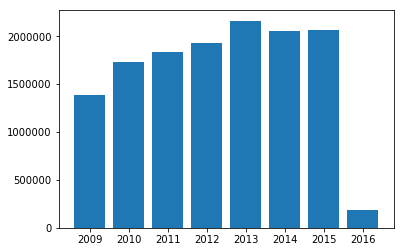

In [8]:
plt.bar(df_annual.index[:8], df_annual.vacs_administered[:8])
plt.show()

### Number of flu shots given each month; we can use this to represent how many flu shots were given outside of flu season (i.e. June - either August or September)

In [9]:
# groupby month, rename columns, drop ID column and add a total
df_by_month = df.groupby(by=df['VACCINATION_DATE'].map(
    lambda x: x.month)).count().drop(df.columns[1:], 1)
df_by_month['Vaccines_Administered'] = df_by_month.ID
df_by_month.drop('ID', 1, inplace=True)
df_by_month.loc['total'] = df_by_month.Vaccines_Administered.sum()

In [10]:
df_by_month

,Vaccines_Administered
VACCINATION_DATE,
1,710854
2,254181
3,132395
4,41213
5,16323
6,7150
7,2912
8,237774
9,2939734


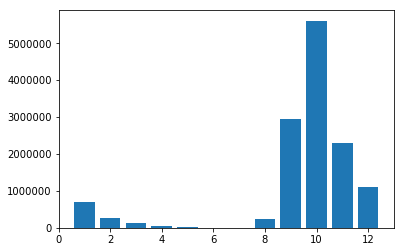

In [11]:
plt.bar(df.index[:12]+1, df_by_month.Vaccines_Administered[:12])
plt.show()

### Number of Vaccines Administered at Each Age (in months)
* may be interesting to comment on number of vacs administered to kids < 6 months

In [12]:
df_months = df.groupby('AGE_IN_MONTHS').count()
df_months.drop(df_months.columns[1:], 1, inplace=True)

In [38]:
df_months[:20]

,ID
AGE_IN_MONTHS,
0,593
1,226
2,518
3,217
4,553
5,6109
6,151238
7,90661
8,34569


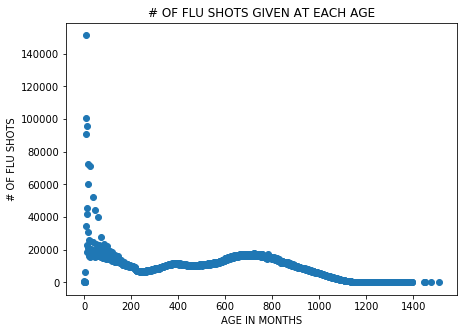

In [14]:
plt.figure(figsize=(7,5))
plt.scatter(df_months.index, df_months.ID)
plt.title('# OF FLU SHOTS GIVEN AT EACH AGE')
plt.xlabel("AGE IN MONTHS")
plt.ylabel("# OF FLU SHOTS")
plt.show()

### Definie Flu Season:
* each flu season starts in July and ends at the end of June, i.e. 07/year - 06/year
* e.g. June of 2016 is in fluseason 2015
* [CDC does year 2016-2017](https://www.cdc.gov/flu/professionals/)

In [15]:
def define_flu_season(row):
    month = row.month
    year = row.year
    if month in [7, 8, 9, 10, 11, 12]:
        return year
    elif month in [1, 2, 3, 4, 5, 6]:
        return year-1

In [16]:
df = df.assign(flu_season = df['VACCINATION_DATE'].map(lambda row: define_flu_season(row)))
df = df.assign(VACCINE_COUNT = 1)
df_vaccine_counts = df

### Split the data into two groups: those > 96m and those <= 96 months and merge into one dataframe

In [60]:
# took the max of the months. Kids who turn > 96 m during flu season do not need another shot, 
# so I took the max to be able to filter out seasons where the kid was < 96m old
df_vc_grouped = df_vaccine_counts.groupby(['ID', 'flu_season']).agg({"AGE_IN_MONTHS" : max, "VACCINE_COUNT" : np.sum})

# filter by age and count the number of number of seasons where x vacs were given
above_eight_df = df_vc_grouped[df_vc_grouped.AGE_IN_MONTHS > 96]
above_eight = above_eight_df.VACCINE_COUNT.value_counts().to_frame().sort_index()
below_eight_df = df_vc_grouped[df_vc_grouped.AGE_IN_MONTHS <= 96]
below_eight = below_eight_df.VACCINE_COUNT.value_counts().to_frame().sort_index()

# rename columns
below_eight['num_seasons (<= 96m)'] = below_eight.VACCINE_COUNT
below_eight.drop('VACCINE_COUNT', 1, inplace=True)
above_eight['num_seasons (> 96m)'] = above_eight.VACCINE_COUNT
above_eight.drop('VACCINE_COUNT', 1, inplace=True)

# merge data into one df
vaccines_received_per_season = pd.merge(above_eight, below_eight, how="outer", right_index=True, left_index=True)
vaccines_received_per_season.fillna(0, inplace=True)

# calucluate totals
vaccines_received_per_season['total_vacs'] = (vaccines_received_per_season['num_seasons (> 96m)']
                                              + vaccines_received_per_season['num_seasons (<= 96m)']) * vaccines_received_per_season.index

# rename index
vaccines_received_per_season.index.rename("Flu_shots_per_season", inplace=True)

In [18]:
vaccines_received_per_season

,num_seasons (> 96m),num_seasons (<= 96m),total_vacs
Flu_shots_per_season,,,
1,10380923.0,1679112.0,12060035.0
2,301731.0,324236.0,1251934.0
3,4662.0,4045.0,26121.0
4,114.0,221.0,1340.0
5,6.0,12.0,90.0
6,3.0,2.0,30.0
7,0.0,1.0,7.0
8,1.0,0.0,8.0
9,0.0,1.0,9.0


Summing on the total_vacs column gives 13339584, which is the same length as the original dataset.

### Count the number of inappropriate vacs administered to kids < 96m
* definition of appropriate: 
    * one sesaon when 2 vacs were administered between 6m and 96m
    * otherwise only 1 vac per season
* def of inappropriate: 
    * any occasion 2 vacs were administered in the same flu season with the child already having received 2 vacs in a single season in the past
    * any occasion > 2 vacs were administered in a flu season

In [19]:
# reset the index from the grouped df to execute loop below
below_eight_df.reset_index(inplace=True)

In [20]:
result_dict = {}
only_one = []
correct = []
inappropriate_vacs_one_mult = []
inappropriate_vacs_mult_mult = []

for ID, vaccinations in below_eight_df.groupby('ID'):
    
    max_count = vaccinations.VACCINE_COUNT.max()
    vacs_counts_per_season = vaccinations.VACCINE_COUNT.value_counts()
    n_mult_vac_seasons = vacs_counts_per_season[vacs_counts_per_season.index > 1].sum()
    
    # never received 2 vacs
    if max_count < 2:
        only_one.append(ID)
        continue
        
    # 2 vacs received in only one season
    if max_count == 2 and n_mult_vac_seasons == 1:
        correct.append(ID)
        continue

    # more than 2 vacs in only one season
    if max_count > 2 and n_mult_vac_seasons == 1:
        inappropriate_vac_count = max_count - 2
        inappropriate_vacs_one_mult.append((ID, inappropriate_vac_count, n_mult_vac_seasons))
        continue
    
    # >= 2 vacs in more than one season
    if max_count >= 2 and n_mult_vac_seasons > 1:
        # get all rows with vacs > 2 and sum them to get vac total; subtract to to get the count of excessive vacs
        seasons_with_mult_vacs_counts = vaccinations[vaccinations.VACCINE_COUNT > 1]["VACCINE_COUNT"]
        inappropriate_vac_count = seasons_with_mult_vacs_counts.sum() - 2
        return_vals = list(seasons_with_mult_vacs_counts.values)
        
        # remove one instance when a child received 2 vacs, as one instance is appropriate
        try:
            return_vals.remove(2)
        except:
            pass
        
        inappropriate_vacs_mult_mult.append((ID, inappropriate_vac_count, return_vals))
        continue
        
result_dict["only_one"] = only_one
result_dict["correct"] = correct
result_dict["inappropriate_vacs_one_multi_vac_seasons"] = inappropriate_vacs_one_mult
result_dict["inappropriate_vacs_mult_multi_vac_seasons"] = inappropriate_vacs_mult_mult

In [21]:
inappropriate_vacs = result_dict["inappropriate_vacs_one_multi_vac_seasons"] + result_dict["inappropriate_vacs_mult_multi_vac_seasons"]

### Total number people of those w/ age <= 96m:
* note this is those who were <= 96m at the time they received their last vaccine w/in a given flu season

In [22]:
total_below_eight = 0
for k in result_dict.keys():
    total_below_eight += len(result_dict[k])

# passes assertion test
assert total_below_eight == below_eight_df.ID.nunique()

total_below_eight

796128

### Total number of people  w/ age > 96m:
* note this is those who were > 96m at the time they received their last vaccine within a given flu season (if they received multiple)

In [23]:
above_eight_df = df_vc_grouped[df_vc_grouped.AGE_IN_MONTHS > 96].reset_index()

In [24]:
total_above_eight = above_eight_df.ID.nunique()
total_above_eight

3519982

### Total number of unique ID's in the dataset:
* note this will not equal total_above_eight + total_below_eight as a given ID can be in both categories as they age

In [25]:
df.ID.nunique()

4137453

Note: total number of those > 96 and 

### Number of those age < 96m who never had a season in which they received two vaccines:

In [26]:
only_one_len = len(result_dict["only_one"])

### Number of those age < 96m who received two vaccines in only one flu season (i.e. appropriate vaccination):

In [27]:
len(result_dict["correct"])

308607

### Number of those age < 96m who had only 1 season in which they received > 1 vac, yet received > 2 vacs in that season:

In [28]:
len(result_dict["inappropriate_vacs_one_multi_vac_seasons"])

3915

### Number of those age < 96m who had multiple seasons in which they received >= 2 vacs:

In [29]:
len(result_dict["inappropriate_vacs_mult_multi_vac_seasons"])

7878

### Number of inappropriate vacs in those <= 96m:

In [30]:
# create a Counter object that counts the number of instances of having x excessive vacs
count = Counter()
for num in result_dict["inappropriate_vacs_one_multi_vac_seasons"]:
    num = num[1]
    count[num]+=1
for num in result_dict["inappropriate_vacs_mult_multi_vac_seasons"]:
    for n in num[2]: 
        count[n]+=1

In [31]:
count

Counter({1: 3709, 2: 7949, 3: 348, 4: 30, 6: 1, 7: 2})

In [32]:
num_inapp_vacs = 0
for k in count.keys():
    num_inapp_vacs += count[k] * k

num_inapp_vacs

20791

### Total Number of Vaccines given to kids <= 96m:

In [33]:
# these will not be equal if a kid received two 
# vaccines in the same season and was 95 months for the first and 97 
# months for the second, they will be classed in those above 8

# This raises an AssertionError
# assert df[df.AGE_IN_MONTHS <= 96].shape[0] == below_eight_df.VACCINE_COUNT.sum()

total_vacs = below_eight_df.VACCINE_COUNT.sum()
total_vacs

2340691

### Percentage of kids <= 96m who received an excessive number of vaccines:
* .888 % of vacs given to kids <= 96m were inappropriate

In [34]:
float("{:.3f}".format(num_inapp_vacs / total_vacs * 100))

0.888

### Percentage of those > 96m who received an excessive number of vaccines


In [35]:
# create df for those receiving excessive vacs with age > 96m
inapp_seasons_older = df_vc_grouped[(df_vc_grouped.AGE_IN_MONTHS > 96) & (df_vc_grouped.VACCINE_COUNT >= 2)]
inapp_seasons_older = inapp_seasons_older.assign(num_seasons_old=(inapp_seasons_older.VACCINE_COUNT - 1))
old_vac_counts = inapp_seasons_older.num_seasons_old.value_counts().to_frame().sort_index()

# create df for those receiving excessive vacs w/ age <= 96m
younger_inapp_vacs = pd.DataFrame(data=list(count.values()), index=list(count.keys()), columns=["num_seasons_young"])
young_vac_counts = younger_inapp_vacs.sort_index()

# merge, fill empty values
inappropriate_vacs = pd.merge(old_vac_counts, young_vac_counts, how="outer", right_index=True, left_index=True).fillna(0)

# calculate total number of vacs given for each subtype and overall
inappropriate_vacs['total_vacs_old'] = (inappropriate_vacs.num_seasons_old * inappropriate_vacs.index)
inappropriate_vacs['total_vacs_young'] = inappropriate_vacs.num_seasons_young * inappropriate_vacs.index
inappropriate_vacs['total'] = inappropriate_vacs.total_vacs_old + inappropriate_vacs.total_vacs_young

for col in inappropriate_vacs.columns[2:]:
    inappropriate_vacs.loc["aggregate_totals", col] = inappropriate_vacs[col].sum()
inappropriate_vacs.fillna("n/a", inplace=True)

inappropriate_vacs['total_percent'] = inappropriate_vacs.total / inappropriate_vacs.loc['aggregate_totals', 'total'] * 100

# rename df
inappropriate_vacs.index.rename("# of excessive vacs", inplace=True)

In [36]:
inappropriate_vacs

,num_seasons_old,num_seasons_young,total_vacs_old,total_vacs_young,total,total_percent
# of excessive vacs,,,,,,
1,301731,3709,301731.0,3709.0,305440.0,91.932712
2,4662,7949,9324.0,15898.0,25222.0,7.591432
3,114,348,342.0,1044.0,1386.0,0.417165
4,6,30,24.0,120.0,144.0,0.043342
5,3,0,15.0,0.0,15.0,0.004515
6,0,1,0.0,6.0,6.0,0.001806
7,1,2,7.0,14.0,21.0,0.006321
9,1,0,9.0,0.0,9.0,0.002709
aggregate_totals,n/a,n/a,311452.0,20791.0,332243.0,100.000000


In [37]:
print("Number of vacs given to those <= 96m: ", df_vc_grouped[df_vc_grouped.AGE_IN_MONTHS <= 96]['VACCINE_COUNT'].sum())
print("Number of vacs given to those > 96m: ", df_vc_grouped[df_vc_grouped.AGE_IN_MONTHS > 96]['VACCINE_COUNT'].sum())
print("Number of inapprorpiate vacs given to <= 96m: ", inappropriate_vacs.loc['aggregate_totals', 'total_vacs_young'])
print("Number of inapprorpiate vacs given to > 96m: ", inappropriate_vacs.loc['aggregate_totals', 'total_vacs_old'])

Number of vacs given to those <= 96m:  2340691
Number of vacs given to those > 96m:  10998893
Number of inapprorpiate vacs given to <= 96m:  20791.0
Number of inapprorpiate vacs given to > 96m:  311452.0


### IDs of those who were inappropriately vaccinated

In [56]:
id_list = []
for entry in result_dict["inappropriate_vacs_mult_multi_vac_seasons"]:
    id_list.append(entry[0])
for entry in result_dict["inappropriate_vacs_one_multi_vac_seasons"]:
    id_list.append(entry[0])

ids_young = id_list
ids_old = df_vc_grouped[(df_vc_grouped.AGE_IN_MONTHS > 96) & (df_vc_grouped.VACCINE_COUNT > 1)].reset_index()['ID'].values.tolist()

### Number of clinics those who received inappropriate vacs attended

In [61]:
df_nunique_orgs = df_vaccine_counts.groupby(['ID', 'flu_season']).agg({"AGE_IN_MONTHS" : max, "VACCINE_COUNT" : np.sum, 
                                                                       "ENTERED_BY_ORG" : pd.Series.nunique})

In [85]:
old_org_count = df_nunique_orgs[(df_nunique_orgs.VACCINE_COUNT> 1) & (df_nunique_orgs.AGE_IN_MONTHS > 96)]['ENTERED_BY_ORG'].value_counts().to_frame().sort_index()
old_org_count.index.rename("num_clinics", inplace=True)
old_org_count

,ENTERED_BY_ORG
num_clinics,
1,32816
2,271344
3,2337
4,19
5,1
6,1


In [86]:
df_young_orgs = df_nunique_orgs.reset_index()
young_org_count = df_young_orgs[df_young_orgs.ID.isin(ids_young)]['ENTERED_BY_ORG'].value_counts().to_frame()
young_org_count.index.rename("num_clinics", inplace=True)
young_org_count

,ENTERED_BY_ORG
num_clinics,
1,39710
2,6423
3,222
